## 모듈 및 데이터 불러오기

In [220]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import datetime

import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# pandas 옵션 설정
pd.options.display.max_columns = 80
pd.options.display.precision = 15

# 한글 글꼴 설정
font_name = font_manager.FontProperties(fname="/usr/share/fonts/nhn-nanum/NanumGothic.ttf").get_name()
rc('font', family=font_name)

# 경고메세지 무시
import warnings
warnings.filterwarnings(action='ignore')

In [221]:
# 데이터 Load
df = pd.read_csv('data/raw_data/labeled.csv')

## 불필요한 데이터 제거 및 전처리

In [222]:
# 중복 데이터 삭제
print('기존 데이터 개수:', len(df))
df.drop_duplicates(inplace = True)
print('중복 제거 후 데이터 개수:', len(df))

기존 데이터 개수: 7996
중복 제거 후 데이터 개수: 5232


In [223]:
# 데이터를 모델 학습에 적절한 타입으로 변경
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df['PassOrFail'] = df['PassOrFail'].map({'Y':0, 'N':1})

In [224]:
# 데이터 종류 및 개수 확인
print(df['EQUIP_NAME'].value_counts())
print()
print(df['PART_NAME'].value_counts())

650톤-우진2호기    5230
1800TON-우진       1
650톤-우진          1
Name: EQUIP_NAME, dtype: int64

CN7 W/S SIDE MLD'G RH        1989
CN7 W/S SIDE MLD'G LH        1985
RG3 MOLD'G W/SHLD, LH         628
RG3 MOLD'G W/SHLD, RH         628
SP2 CVR ROOF RACK CTR, RH       1
JX1 W/S SIDE MLD'G RH           1
Name: PART_NAME, dtype: int64


In [225]:
# 650톤-우진2호기의 데이터만 추출 후 의미가 없어진 EQUIP_NAME과 EQUIP_CD컬럼 삭제
df = df[df['EQUIP_NAME'] == '650톤-우진2호기']
df.drop(['EQUIP_NAME', 'EQUIP_CD'], axis = 1, inplace = True)

In [226]:
# 데이터 통계량 파악
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PART_FACT_SERIAL,5230.0,11.816634799235182,5.017871155933895,3.000000000000000,9.000000000000000,10.000000000000000,13.000000000000000,24.000000000000000
PassOrFail,5230.0,0.011472275334608,0.106502727827037,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,1.000000000000000
Injection_Time,5230.0,7.530449362193194,3.640406831551406,1.049999952316284,9.500000000000000,9.539999961853027,9.579999923706056,13.390000343322754
Filling_Time,5230.0,3.603259991961273,1.503582291323854,0.930000007152557,4.380000114440918,4.429999828338623,4.469999790191650,8.270000457763672
Plasticizing_Time,5230.0,15.909808784142051,1.692147977540736,12.800000190734863,16.540000915527344,16.799999237060547,16.920000076293945,21.100000381469727
Cycle_Time,5230.0,60.078009592643433,0.998441249051180,58.840000152587891,59.520000457763672,59.520000457763672,59.649999618530273,64.349998474121094
Clamp_Close_Time,5230.0,7.040084123064410,0.147159057186711,6.070000171661377,7.110000133514404,7.119999885559082,7.119999885559082,7.179999828338623
Cushion_Position,5230.0,653.632786522130459,0.360955100863898,653.390014648437500,653.429992675781250,653.440002441406250,653.460021972656250,655.000000000000000
Switch_Over_Position,5230.0,0.501193114767567,18.117627518026477,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,655.309997558593750
Plasticizing_Position,5230.0,64.853120242933926,6.357645189645844,53.549999237060547,68.239997863769531,68.339996337890625,68.489997863769531,68.860000610351562


In [227]:
# 의미 없는 컬럼 삭제
df.drop(['_id', 'Reason'], axis = 1, inplace = True)

# 모든 값이 0인 컬럼 삭제 (Switch_Over_Position은 2개의 행을 제외한 모든 데이터가 0이므로 삭제)
df.drop(['Mold_Temperature_1', 'Mold_Temperature_2', 'Mold_Temperature_5', 'Mold_Temperature_6',
          'Mold_Temperature_7', 'Mold_Temperature_8', 'Mold_Temperature_9', 'Mold_Temperature_10',
          'Mold_Temperature_11', 'Mold_Temperature_12', 'Barrel_Temperature_7', 'Switch_Over_Position'], axis = 1, inplace = True)

df.reset_index(drop = True, inplace = True)

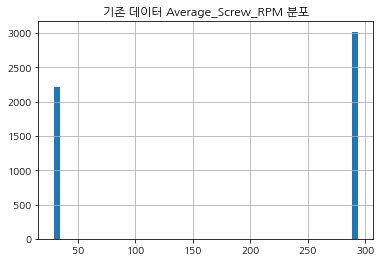

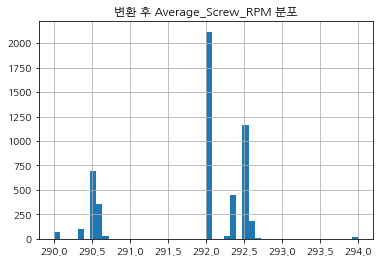

In [228]:
# Average_Screw_RPM의 분포 시각화
df['Average_Screw_RPM'].hist(bins = 50)
plt.title('기존 데이터 Average_Screw_RPM 분포')
plt.show()

# 잘못 표기된 것으로 의심되는 행 변환
for i in range(len(df)):
    if df['Average_Screw_RPM'][i] < 50:
        df['Average_Screw_RPM'][i] = df['Average_Screw_RPM'][i] * 10

# 변환 된 데이터 분포 시각화
df['Average_Screw_RPM'].hist(bins = 50)
plt.title('변환 후 Average_Screw_RPM 분포')
plt.show()

In [229]:
# CN7과 RG3 분리
cn7 = df[df['PART_NAME'].str.contains('CN7')].reset_index(drop = True)
rg3 = df[df['PART_NAME'].str.contains('RG3')].reset_index(drop = True)

In [230]:
# TimeStamp가 중복되지 않고 1개인 행들의 index 추출
c = pd.DataFrame(cn7['TimeStamp'].value_counts())
ctime = c[c['TimeStamp'] == 1].index
r = pd.DataFrame(rg3['TimeStamp'].value_counts())
rtime = r[r['TimeStamp'] == 1].index

# TimeStamp를 인덱스로 설정
cn7 = cn7.set_index('TimeStamp', drop = True)
rg3 = rg3.set_index('TimeStamp', drop = True)

# TimeStamp가 중복되지 않고 1개인 행 삭제
cn7 = cn7.drop(c[c['TimeStamp'] == 1].index, axis = 0)
rg3 = rg3.drop(r[r['TimeStamp'] == 1].index, axis = 0)

# 인덱스 reset
cn7.reset_index(inplace = True)
rg3.reset_index(inplace = True)

In [231]:
print('CN7 행 개수:', len(cn7))
print('RG3 행 개수:', len(rg3))

CN7 행 개수: 3958
RG3 행 개수: 1254


In [233]:
# cn7의 데이터에서 TimeStamp를 기준으로 평균으로 그룹화 한 것과 최대 값으로 그룹화 한 것을 비교
cn7_group_mean = cn7.groupby(cn7['TimeStamp']).mean().drop(['PassOrFail', 'PART_FACT_SERIAL'], axis = 1)
cn7_group_max = cn7.groupby(cn7['TimeStamp']).max().drop(['PassOrFail', 'PART_NAME', 'PART_FACT_SERIAL', 'PART_FACT_PLAN_DATE'], axis = 1)
np.sum(cn7_group_mean == cn7_group_max) # 평균으로 그룹화 한 것과 최대 값으로 그룹화 한 것이 모두 같고 기존 CN7 행 개수에서 정확히 절반으로 줄었으므로 같은 TimeStamp에서 모든 값이 같은 것을 확인

Injection_Time              1979
Filling_Time                1979
Plasticizing_Time           1979
Cycle_Time                  1979
Clamp_Close_Time            1979
Cushion_Position            1979
Plasticizing_Position       1979
Clamp_Open_Position         1979
Max_Injection_Speed         1979
Max_Screw_RPM               1979
Average_Screw_RPM           1979
Max_Injection_Pressure      1979
Max_Switch_Over_Pressure    1979
Max_Back_Pressure           1979
Average_Back_Pressure       1979
Barrel_Temperature_1        1979
Barrel_Temperature_2        1979
Barrel_Temperature_3        1979
Barrel_Temperature_4        1979
Barrel_Temperature_5        1979
Barrel_Temperature_6        1979
Hopper_Temperature          1979
Mold_Temperature_3          1979
Mold_Temperature_4          1979
dtype: int64

In [234]:
# cn7과 동일하게 확인
rg3_group_mean = rg3.groupby(rg3['TimeStamp']).mean().drop(['PassOrFail', 'PART_FACT_SERIAL'], axis = 1)
rg3_group_max = rg3.groupby(rg3['TimeStamp']).max().drop(['PassOrFail', 'PART_NAME', 'PART_FACT_SERIAL', 'PART_FACT_PLAN_DATE'], axis = 1)
np.sum(rg3_group_mean == rg3_group_max)

Injection_Time              627
Filling_Time                627
Plasticizing_Time           627
Cycle_Time                  627
Clamp_Close_Time            627
Cushion_Position            627
Plasticizing_Position       627
Clamp_Open_Position         627
Max_Injection_Speed         627
Max_Screw_RPM               627
Average_Screw_RPM           627
Max_Injection_Pressure      627
Max_Switch_Over_Pressure    627
Max_Back_Pressure           627
Average_Back_Pressure       627
Barrel_Temperature_1        627
Barrel_Temperature_2        627
Barrel_Temperature_3        627
Barrel_Temperature_4        627
Barrel_Temperature_5        627
Barrel_Temperature_6        627
Hopper_Temperature          627
Mold_Temperature_3          627
Mold_Temperature_4          627
dtype: int64

In [235]:
# TimeStamp를 기준으로 LH와 RH를 그룹화 후 의미가 없어진 PART_NAME, PART_FACT_SERIAL컬럼 삭제
cn7 = cn7.groupby(cn7['TimeStamp']).max().drop(['PART_NAME', 'PART_FACT_SERIAL'], axis = 1).reset_index()
rg3 = rg3.groupby(rg3['TimeStamp']).max().drop(['PART_NAME', 'PART_FACT_SERIAL'], axis = 1).reset_index()

In [130]:
# 전처리가 완료된 데이터프레임 저장
cn7.to_csv('cn7.csv')
rg3.to_csv('rg3.csv')